# IMU Integrator tutorial

## 1. Что такое интегрирование IMU
Инерциальный измерительный блок (IMU) - это устройство, которое может измерять ускорение и угловую скорость.     
Обычно IMU состоит из:
- гироскопа, измеряющего угловую скорость вдоль заданной оси
- акселерометра, измеряющего линейные ускорения
Используя ускорение и угловую скорость, мы можем получить скорость и положение, используя базовую кинематику:
- Первым интегралом ускорения с течением времени является изменение скорости
- Вторым интегральным показателем ускорения во времени является изменение положения объекта в пространстве
Этот процесс называется предварительным интегрированием IMU и часто используется в приложениях робототехники, таких как SLAM (одновременная локализация и картографирование).

***Неопределенность***
Однако измерения IMU содержат очень большой шум. Например, если мы установим  датчик IMU в статическое положение, результаты измерений будут приближаться к нулю. Вот почему, чем больше мы интегрируем, тем более неопределенными мы становимся. Эта неопределенность также может быть измерена математически. Пожалуйста, обратитесь к документу для получения математических данных.       
Математические подробности содержатся в документации к классу `pypose.module.IMUPreintegrator`

In [22]:
import os
import time
import argparse
import torch
import pykitti
import numpy as np
import pypose as pp
from datetime import datetime
import torch.utils.data as Data
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

%matplotlib widget

## Подготовка датасета
Мы используем пакет pykitti. Этот пакет предоставляет минимальный набор инструментов для работы с наборами данных KITTI. Чтобы получить доступ к последовательности данных, используйте:     
`dataset = pykitti.raw(root, dataname, drive)`
Ниже приведены некоторые из атрибутов данных, которые мы использовали:    
- `dataset.timestamps`: Временные метки преобразуются в список объектов datetime
- `dataset.oxts`: Список пакетов OXTS и 6-dof поз в виде именованных кортежей    
  
Последовательность будет разделена на множество сегментов. Количество сегментов определяется параметром step_size. Каждый сегмент последовательности будет возвращать данные измерений, такие как dt, acc и gyro, для нескольких кадров, определяемых длительностью.

In [4]:
kitti_root = 'D:\\datasets\\kitti_raw_data'
dataname = '2011_09_26'
drive = '0001'

In [5]:
dataset = pykitti.raw(kitti_root, dataname, drive)

In [6]:
class KITTI_IMU(Data.Dataset):
    def __init__(self, root, dataname, drive, duration=10, step_size=1, mode='train'):
        super().__init__()
        self.duration = duration
        self.data = pykitti.raw(root, dataname, drive)
        self.seq_len = len(self.data.timestamps) - 1
        assert mode in ['evaluate', 'train',
                        'test'], "{} mode is not supported.".format(mode)

        self.dt = torch.tensor([datetime.timestamp(self.data.timestamps[i+1]) -
                               datetime.timestamp(self.data.timestamps[i])
                               for i in range(self.seq_len)])
        self.gyro = torch.tensor([[self.data.oxts[i].packet.wx,
                                   self.data.oxts[i].packet.wy,
                                   self.data.oxts[i].packet.wz]
                                   for i in range(self.seq_len)])
        self.acc = torch.tensor([[self.data.oxts[i].packet.ax,
                                  self.data.oxts[i].packet.ay,
                                  self.data.oxts[i].packet.az]
                                  for i in range(self.seq_len)])
        self.gt_rot = pp.euler2SO3(torch.tensor([[self.data.oxts[i].packet.roll,
                                                  self.data.oxts[i].packet.pitch,
                                                  self.data.oxts[i].packet.yaw]
                                                  for i in range(self.seq_len)]))
        self.gt_vel = self.gt_rot @ torch.tensor([[self.data.oxts[i].packet.vf,
                                                   self.data.oxts[i].packet.vl,
                                                   self.data.oxts[i].packet.vu]
                                                   for i in range(self.seq_len)])
        self.gt_pos = torch.tensor(
            np.array([self.data.oxts[i].T_w_imu[0:3, 3] for i in range(self.seq_len)]))

        start_frame = 0
        end_frame = self.seq_len
        if mode == 'train':
            end_frame = np.floor(self.seq_len * 0.5).astype(int)
        elif mode == 'test':
            start_frame = np.floor(self.seq_len * 0.5).astype(int)

        self.index_map = [i for i in range(
            0, end_frame - start_frame - self.duration, step_size)]

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, i):
        frame_id = self.index_map[i]
        end_frame_id = frame_id + self.duration
        return {
            'dt': self.dt[frame_id: end_frame_id],
            'acc': self.acc[frame_id: end_frame_id],
            'gyro': self.gyro[frame_id: end_frame_id],
            'gyro': self.gyro[frame_id: end_frame_id],
            'gt_pos': self.gt_pos[frame_id+1: end_frame_id+1],
            'gt_rot': self.gt_rot[frame_id+1: end_frame_id+1],
            'gt_vel': self.gt_vel[frame_id+1: end_frame_id+1],
            'init_pos': self.gt_pos[frame_id][None, ...],
            # TODO: the init rotation might be used in gravity compensation
            'init_rot': self.gt_rot[frame_id: end_frame_id],
            'init_vel': self.gt_vel[frame_id][None, ...],
        }

    def get_init_value(self):
        return {
            'pos': self.gt_pos[:1],
            'rot': self.gt_rot[:1],
            'vel': self.gt_vel[:1]
        }

In [7]:
# Вспомогательные функции
def imu_collate(data):
    """Эта функия используется в пакетном режиме для
    объединения данных в нескольких кадрах вместе.
    """
    acc = torch.stack([d['acc'] for d in data])
    gyro = torch.stack([d['gyro'] for d in data])

    gt_pos = torch.stack([d['gt_pos'] for d in data])
    gt_rot = torch.stack([d['gt_rot'] for d in data])
    gt_vel = torch.stack([d['gt_vel'] for d in data])

    init_pos = torch.stack([d['init_pos'] for d in data])
    init_rot = torch.stack([d['init_rot'] for d in data])
    init_vel = torch.stack([d['init_vel'] for d in data])

    dt = torch.stack([d['dt'] for d in data]).unsqueeze(-1)

    return {
        'dt': dt,
        'acc': acc,
        'gyro': gyro,

        'gt_pos': gt_pos,
        'gt_vel': gt_vel,
        'gt_rot': gt_rot,

        'init_pos': init_pos,
        'init_vel': init_vel,
        'init_rot': init_rot,
    }

# plot_gaussian используется для построения эллипса, измеряющего неопределенность,
# больший эллипс означает большую неопределенность.
def plot_gaussian(ax, means, covs, color=None, sigma=3):
    ''' Set specific color to show edges, otherwise same with facecolor.'''
    ellipses = []
    for i in range(len(means)):
        eigvals, eigvecs = np.linalg.eig(covs[i])
        axis = np.sqrt(eigvals) * sigma
        slope = eigvecs[1][0] / eigvecs[1][1]
        angle = 180.0 * np.arctan(slope) / np.pi
        ellipses.append(Ellipse(means[i, 0:2], axis[0], axis[1], angle=angle))
    ax.add_collection(PatchCollection(ellipses, edgecolors=color, linewidth=1))


In [10]:
torch.set_default_dtype(torch.float32)

## Выполнение интегрирования
После того, как все настроено, мы приступим к основной операции интегрирования IMU. В приведенных ниже коде в основном 5 шагов:
1. Определим загружчик данных
2. Установим начальные положение, поворот и скорость. В данном случае они все будут равны 0.
3. Определим IMUPreintegrator
4. Выполним интегрирование
После запуска прямой функции интегратора результат сохраняется в состоянии, где состояние ['pos'] - это интегрированное положение, а состояние ['cov'] - это измерения неопределенности.    
Обратите внимание, что состояние ['cov'] представляет собой матрицу размером 9x9 в порядке вращения, скорости и положения. Вот почему в визуализации мы используем covs[:, 6:8, 6:8] здесь: они представляют собой ковариационную матрицу положения x и y.     
5. Визуализация

In [29]:
# Step 1. Define dataloader using the ``KITTI_IMU`` class we defined above 
dataset = KITTI_IMU(
    kitti_root, dataname, drive, 
    duration=15, step_size=15, mode='evaluate'
)
loader = Data.DataLoader(
    dataset=dataset,
    batch_size=1,
    collate_fn=imu_collate,
    shuffle=False
)
# Step 2: Get the initial position, rotation and velocity, all 0 here
init = dataset.get_init_value()
# Step 3: Define the IMUPreintegrator.
integrator = pp.module.IMUPreintegrator(
    init['pos'],
    init['rot'],
    init['vel'],
    reset=False,
)
# Step 4: Perform integration
poses, poses_gt = [init['pos']], [init['pos']]
covs = [torch.zeros(9, 9)]

# Сразу посчитаем скорость работы интегратора на процессоре
sum_time = 0
for idx, data in enumerate(loader):
    start_time = time.time()
    state = integrator(dt=data['dt'],
                       gyro=data['gyro'],
                       acc=data['acc'],
                       rot=data['init_rot'])
    end_time = time.time()
    dt = end_time - start_time
    sum_time += dt
    poses_gt.append(data['gt_pos'][..., -1, :])
    poses.append(state['pos'][..., -1, :])
    covs.append(state['cov'][..., -1, :, :])
mean_time = sum_time / (idx + 1)
print(f"Среднее время выполнения операции интегрирования: {mean_time} сек.")

poses = torch.cat(poses).numpy()
poses_gt = torch.cat(poses_gt).numpy()
covs = torch.stack(covs, dim=0).numpy()

Среднее время выполнения операции интегрирования: 0.00699993542262486 сек.


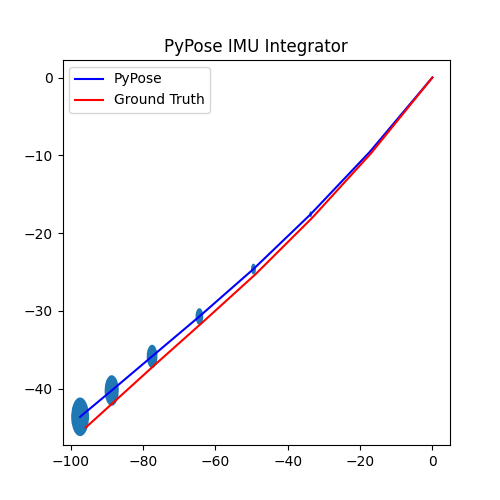

In [30]:
# Step 5.1 2D visualization
plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.plot(poses[:, 0], poses[:, 1], 'b')
ax.plot(poses_gt[:, 0], poses_gt[:, 1], 'r')
plot_gaussian(ax, poses[:, 0:2], covs[:, 6:8, 6:8])
plt.title("PyPose IMU Integrator")
plt.legend(["PyPose", "Ground Truth"])

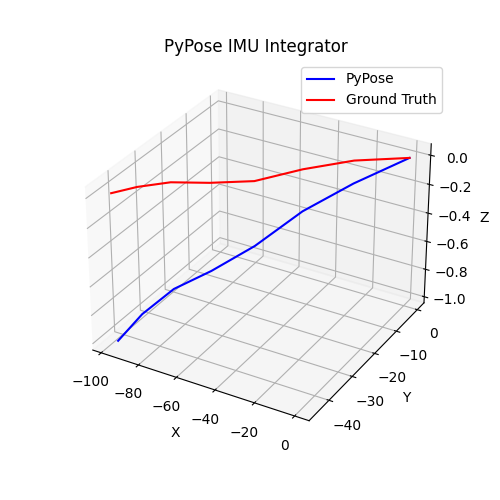

In [32]:
# Step 5.2 3D visualization
plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.plot3D(poses[:, 0], poses[:, 1], poses[:, 2], 'b')
ax.plot3D(poses_gt[:, 0], poses_gt[:, 1], poses_gt[:, 2], 'r')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel('Z')
plt.title("PyPose IMU Integrator")
plt.legend(["PyPose", "Ground Truth"])


### Посчитаем частоту данных imu

In [26]:
# Частота данных imu равна 10 Гц.
dataset.dt.mean()

tensor(0.1032)